In [1]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd

2024-12-10 16:11:03.768432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 16:11:03.785424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 16:11:03.790714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 16:11:03.803836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vlad.cristescu/miniconda3/env

In [2]:
# Verifică GPU-urile disponibile
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

# # Permite alocarea progresivă a memoriei pe GPU-uri
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
#tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
# Creează strategia pentru distribuire pe GPU-uri
strategy = tf.distribute.MirroredStrategy()

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-12-10 16:11:07.437437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43611 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6
2024-12-10 16:11:07.439342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43611 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6
2024-12-10 16:11:07.441069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43611 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:e1:00.0, compute capability: 8.6


In [ ]:
# Încarcă datele
df = pd.read_csv("../datasets/WELFake_Dataset.csv")


In [17]:
df.head()
print(df["text"].isnull().sum())

0


In [16]:
df = df.dropna(subset=["text"])


In [19]:
texts = df["text"].tolist()
labels = df["label"].tolist()

# Split între date de antrenare și testare
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [20]:
#how many elemens are in texts
print(len(texts))

72095


In [21]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_length = 128

def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

train_tokens = tokenize_texts(train_texts, tokenizer, max_length)
test_tokens = tokenize_texts(test_texts, tokenizer, max_length)

/home/vlad.cristescu/miniconda3/envs/proiect_env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
# Modelul și compilarea trebuie să fie în interiorul strategiei
with strategy.scope():
    # Creează modelul BERT
    model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

    # Compilează modelul
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Antrenare
history = model.fit(
    x={
        "input_ids": train_tokens["input_ids"],
        "attention_mask": train_tokens["attention_mask"]
    },
    y=tf.convert_to_tensor(train_labels, dtype=tf.float32),
    validation_data=(
        {
            "input_ids": test_tokens["input_ids"],
            "attention_mask": test_tokens["attention_mask"]
        },
        tf.convert_to_tensor(test_labels, dtype=tf.float32)
    ),
    epochs=3,
    batch_size=16 * strategy.num_replicas_in_sync  # Ajustează batch size pentru GPU-uri multiple
)

Epoch 1/3
INFO:tensorflow:Collective all_reduce tensors: 198 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 3 all_reduces, num_devices =3, group_size = 3, implementation = CommunicationImplementation.NCCL
INFO:tensorflow:Collective all_reduce tensors: 198 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 3 all_reduces, num_devices =3, group_size = 3, implementation = CommunicationImplementation.NCCL
1202/1202 [==============================] - 466s 332ms/step - loss: 0.0837 - accuracy: 0.9678 - val_loss: 0.0405 - val_accuracy: 0.9829
Epoch 2/3
1202/1202 [==============================] - 370s 308ms/step - loss: 0.0241 - accuracy: 0.9916 - val_loss: 0.0363 - val_accuracy: 0.9880
Epoch 3/3
1202/1202 [==============================] - 372s 309ms/step - loss: 0.0

In [24]:
results = model.evaluate(
    x={
        "input_ids": test_tokens["input_ids"],
        "attention_mask": test_tokens["attention_mask"]
    },
    y=tf.convert_to_tensor(test_labels, dtype=tf.float32),
    batch_size=16
)
print(f"Test Accuracy: {results[1] * 100:.2f}%")

# Salvare model și tokenizer
model.save_pretrained("../saved_models/saved_bert_model")
tokenizer.save_pretrained("../saved_models/saved_bert_tokenizer")

902/902 [==============================] - 34s 37ms/step - loss: 0.0553 - accuracy: 0.9827
Test Accuracy: 98.27%


2024-12-10 17:09:33.140077: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


('../saved_models/saved_bert_tokenizer/tokenizer_config.json',
 '../saved_models/saved_bert_tokenizer/special_tokens_map.json',
 '../saved_models/saved_bert_tokenizer/vocab.txt',
 '../saved_models/saved_bert_tokenizer/added_tokens.json')

451/451 [==============================] - 25s 42ms/step


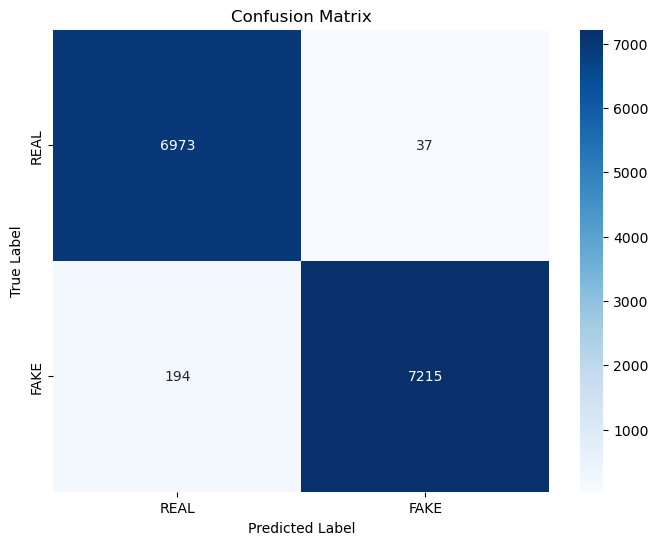

              precision    recall  f1-score   support

        REAL       0.97      0.99      0.98      7010
        FAKE       0.99      0.97      0.98      7409

    accuracy                           0.98     14419
   macro avg       0.98      0.98      0.98     14419
weighted avg       0.98      0.98      0.98     14419

Exemplu 1:
Text: Its impossible to miss the Hillary for Prison signs at Trump rallies. At one of the Democratic debates, the moderator asked Hillary Clinton whether she would drop out of the race if she were indicted over her private email server. Oh for goodness  that is not going to happen, she said. Im not even going to answer that question.

Based on what I know about the emails, the idea of her being indicted or going to prison is nonsensical. Nonetheless, the belief that Clinton is dishonest and untrustworthy is pervasive. A recent New York Times-CBS poll found that 40% of Democrats say she cannot be trusted.

For decades shes been portrayed as a Lady Macbeth

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Obține predicțiile modelului
pred_probs = model.predict({
    "input_ids": test_tokens["input_ids"],
    "attention_mask": test_tokens["attention_mask"]
})["logits"]
predictions = (pred_probs > 0).astype(int).flatten()  # Threshold la 0 pentru predicții binare

# Creează matricea de confuzie
cm = confusion_matrix(test_labels, predictions)

# Vizualizează matricea de confuzie
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Raport de clasificare
print(classification_report(test_labels, predictions, target_names=["REAL", "FAKE"]))

wrong_predictions = [
    {"text": test_texts[i], "true_label": test_labels[i], "predicted_label": predictions[i]}
    for i in range(len(test_labels))
    if test_labels[i] != predictions[i]
]

# Afișează primele 5 greșeli
for i, example in enumerate(wrong_predictions[:5]):
    print(f"Exemplu {i+1}:")
    print(f"Text: {example['text']}")
    print(f"Etichetă adevărată: {'REAL' if example['true_label'] == 0 else 'FAKE'}")
    print(f"Predicție: {'REAL' if example['predicted_label'] == 0 else 'FAKE'}")
    print("\n")

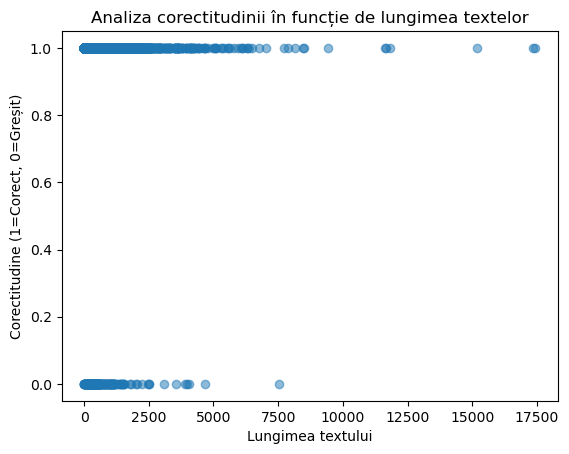

In [26]:
import numpy as np

# Calcularea lungimii textelor
text_lengths = [len(text.split()) for text in test_texts]

# Analiza corectitudinii în funcție de lungimea textului
correct_predictions = [test_labels[i] == predictions[i] for i in range(len(test_labels))]

# Grafic de lungime vs corectitudine
plt.scatter(text_lengths, correct_predictions, alpha=0.5)
plt.xlabel("Lungimea textului")
plt.ylabel("Corectitudine (1=Corect, 0=Greșit)")
plt.title("Analiza corectitudinii în funcție de lungimea textelor")
plt.show()


Text(0, 0.5, 'Number of texts')

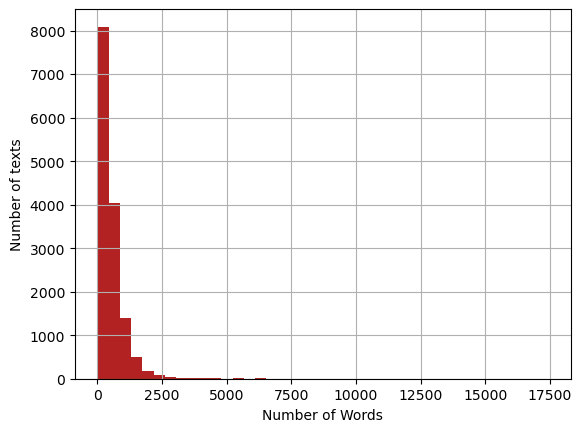

In [28]:
seq_len = [len(text.split()) for text in test_texts]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')